<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-9/Avance9_Equipo10_Evaluation_qwen2_7b_Instruct_16bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

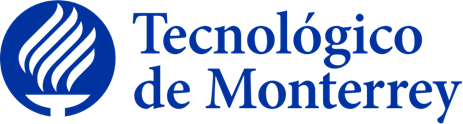

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries and model

In [1]:
# Installs Unsloth, Xformers (Flash Attention) and all other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install datasets
!pip install deepeval
!pip install python-dotenv

from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
#from peft import PeftModel
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import json
from dotenv import load_dotenv
#from transformers.tokenization_utils_base import PreTrainedTokenizerBase
#from transformers.modeling_utils import PreTrainedModel

from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import re


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-vs9g158p/unsloth_25e5c71e2cd44da88efcea0cd75ef296
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-vs9g158p/unsloth_25e5c71e2cd44da88efcea0cd75ef296
  Resolved https://github.com/unslothai/unsloth.git to commit 64bb8cfd512a9dcd860d21563b624676f7432ec5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
#demo_mode = False
#model_name = "unsloth/mistral-7b-v0.3-bnb-4bit"
dataset_url = "JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts"
#peft_model_name = 'rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2'

We proceed to download the main model with unsloth, Qwen2-7b-Instruct.

In [4]:
#model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = model_name,
    #max_seq_length = 2048,
    #device_map='cuda',
    #load_in_4bit = True,
#)

#Load fine tuned model

max_seq_length = 4096

model_fine_tuned, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "a01110946/unsloth-Qwen2-7b-Instruct-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2", # MODEL YOU USED FOR TRAINING
        #model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length, # Could be any since RoPE Scaling is supported.
        dtype = None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
        load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.
        )
FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

adapter_config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Qwen2 patching release 2024.6
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_model.safetensors:   0%|          | 0.00/646M [00:00<?, ?B/s]

Unsloth 2024.6 patched 28 layers with 0 QKV layers, 28 O layers and 28 MLP layers.


### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [5]:
def extract_response(response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )

#def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
def query(model: model_fine_tuned, tokenizer:tokenizer,prompt: str) -> str:
    '''
    Generates the response from the model
    '''

    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = max_seq_length, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)

    return extract_response(result[0])

#def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
def generate_test_cases(model: model_fine_tuned, tokenizer: tokenizer, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []

    if isinstance(datapoints, Dataset):
        datapoints = convert_hugging_face_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        print(datapoint)

        if (isinstance(golden, Golden)):
            datapoint = json.loads(golden.model_dump_json())

        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                #datapoint['instruction'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue

    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases

def convert_hugging_face_dataset_to_goldens(dataset: Dataset)->list[Golden]:

    goldens = []

    for datapoint in dataset:
        if (type(datapoint['context']) != str):
            continue#We need context for some tests
        test_case = Golden(
            input = datapoint['instruction'],
            expected_output = datapoint['output'],
            context = [datapoint['context']]
        )

        test_case.expected_output = datapoint['output']

        goldens.append(test_case)

    return goldens




Function to create test cases using a HuggingFace dataset. Test cases include input (instruction), actual_output (generated response from model), context and expected_output.

In [6]:
#Function to creat deepeval test cases
def create_text_cases(model_fine_tuned, tokenizer, prompt, dataset, max_new_tokens):

  #EOS_TOKEN = tokenizer.eos_token

  #Initialize list and counters at 0
  test_cases = []

  #Assign fast language model to our fine tuned model
  FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

  data_set_counter = 0

  none_context_counter = 0

  none_output_counter = 0

  #Loop to generate test cases using all the dataset
  for i in range(len(dataset)):

    #Increase counter
    data_set_counter = data_set_counter + 1

    #Extract context
    context = dataset[i]['context']

    #Only pass prompts with context
    if context != None:

      #Get required input to format prompt
      context_tokens = tokenizer(dataset[i]['context'])
      input_ids = context_tokens['input_ids']
      portioned_context = ''.join(tokenizer.batch_decode(input_ids)[1:100])
      #portioned_context = dataset[i]['context']

      #Context needs to be contained within a list
      context = [context]

      #print(row)

      text_inputs = [
        alpaca_based_prompt.format(
          dataset[i]['instruction'], # Instrucción
          portioned_context, # Contexto
          #None,
          "", # Salida - leave this blank for generation
          ) #+ EOS_TOKEN
      ]

      #print('Inputs: {}\n\n'.format(text_inputs))

      #Create prompts for text generation
      inputs = tokenizer(
      [
      alpaca_based_prompt.format(
          dataset[i]['instruction'], # Instrucción
          portioned_context, # Contexto
          #None,
          "", # Salida - leave this blank for generation
          ) #+ EOS_TOKEN
      ], return_tensors = "pt").to("cuda")

      #Generate response
      outputs_fine_tuned = model_fine_tuned.generate(**inputs, max_new_tokens = max_new_tokens, use_cache = True, pad_token_id = tokenizer.eos_token_id)
      outputs_fine_tuned_decoded = tokenizer.batch_decode(outputs_fine_tuned)

      model_fined_tuned_response = extract_response(outputs_fine_tuned_decoded[0])

      #print('Response: '+model_fined_tuned_response)
      #print('Context: {}'.format(context))

      #Only create test cases for outputs with text
      if model_fined_tuned_response != None:

        test_case = LLMTestCase(
          input = dataset[i]['instruction'],
          actual_output = model_fined_tuned_response,
          context = context,
          expected_output = dataset[i]['output']
          )


        #Append results and increase counter
        test_cases.append(test_case)
        none_output_counter = none_output_counter + 1
        print('Element {} from {}'.format(i, len(dataset)))


    else:

      none_context_counter = none_context_counter + 1

  #Print progress
  print ('Total None Context Elements: {}'.format(none_context_counter))
  print ('Total None Output Elements: {}'.format(none_context_counter))
  print ('Total Test Cases: {}'.format(len(test_cases)))

  return test_cases

In [7]:
#context_tokens = tokenizer(dataset[0]['context'])
#input_ids = context_tokens['input_ids']
#portioned_context = ''.join(tokenizer.batch_decode(input_ids)[1:21])
#portioned_context

### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [8]:
#Get desired dataset elements for generatin test cases
dataset = load_dataset(dataset_url, split = "test[0:100]")
#test_set = dataset['test']

Generating train split:   0%|          | 0/10072 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1120 [00:00<?, ? examples/s]

In [30]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
import os
from google.colab import userdata

#Get API Key from Colab Secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

### 3. Setting up the Finetuned Model

We define the prompt that we will provide to the language model

In [10]:
#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción

### Instrucción:
{}

### Contexto:
{}

### Respuesta:
{}"""

### 4. Evaluating the Model

Now, we create the test cases from the test partition. 100 testcases were used as standard for all models to evaluate performance taking into consideration time and computational resources required.

In [11]:
#len(test_set)
#len(dataset)

In [12]:
#for row in dataset:
#  print('Context: {}\n\n'.format([row['context']]))

In [13]:
#dataset = test_set.train_test_split(test_size=0.2)

In [14]:
#dataset[59]

In [15]:
#for row in dataset:
#
#  context = row['context']
#  if context != None:

#    context = [context]

#  test_case = LLMTestCase(
#    input=row['instruction'],
#    actual_output=row['output'],
#    context = context
#    )

In [16]:
#print(test_case)

In [17]:
#print(dataset[0]['context'])

In [18]:
#Create test case using the test partition dataset
#test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)
test_cases = create_text_cases(model_fine_tuned, tokenizer, alpaca_based_prompt, dataset, max_seq_length)

Element 0 from 100
Element 1 from 100
Element 2 from 100
Element 3 from 100
Element 4 from 100
Element 5 from 100
Element 6 from 100
Element 7 from 100
Element 8 from 100
Element 9 from 100
Element 11 from 100
Element 12 from 100
Element 13 from 100
Element 14 from 100
Element 15 from 100
Element 16 from 100
Element 17 from 100
Element 18 from 100
Element 19 from 100
Element 20 from 100
Element 21 from 100
Element 22 from 100
Element 23 from 100
Element 24 from 100
Element 25 from 100
Element 26 from 100
Element 27 from 100
Element 28 from 100
Element 29 from 100
Element 30 from 100
Element 31 from 100
Element 32 from 100
Element 33 from 100
Element 34 from 100
Element 35 from 100
Element 36 from 100
Element 37 from 100
Element 38 from 100
Element 39 from 100
Element 40 from 100
Element 41 from 100
Element 42 from 100
Element 43 from 100
Element 44 from 100
Element 45 from 100
Element 46 from 100
Element 47 from 100
Element 48 from 100
Element 49 from 100
Element 50 from 100
Element 51

In [19]:
#for i in range(len(test_cases)):
#    if test_cases[i].actual_output == None:
#      print(i)

Sometimes the language model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [20]:
#test_cases = exclude_test_cases_with_empty_outputs(test_cases)

In [21]:
#dataset_test_cases = EvaluationDataset(test_cases)

In [22]:
from deepeval.dataset.utils import convert_test_cases_to_goldens

goldens = convert_test_cases_to_goldens(test_cases)

In [23]:
backup_dataset = EvaluationDataset(goldens = goldens)
backup_dataset.save_as('json', '/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100')

Evaluation dataset saved at /content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100/20240616_201747.json!


'/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100/20240616_201747.json'

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [24]:
#with open('./content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases'):

In [40]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
import os
#We need a API key .env path
dot_env_path = '/content/drive/MyDrive/MNA/Proyecto Integrador/.env'

#Load .env file
load_dotenv(dot_env_path)

#Get API Key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [41]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

Now we get the results from the test dataset evaluation

In [44]:
results = evaluate(test_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/uti

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [45]:
#results

In [46]:
#with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results') as f:
#    results = json.load(f)

#clean_results = []
#for test_case in results['testCases']:
#    for metric in test_case['metricsMetadata']:
#        if 'error' in metric and metric['error'] == 'Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.':
#           continue


#        clean_results.append(metric)

In [47]:
#len(clean_results)

In [48]:
#clean_results[10]
#results['metric']

In [49]:
#clean_results[0]

In [50]:
#hallucination_metric = []
#for metric in clean_results:
#for metric in results:
#        if metric['metric'] == 'Hallucination':
#            hallucination_metric.append(metric)



#hallucination_metric[0]

In [51]:
#len(hallucination_metric)

In [52]:
#passed = 0

#for metric in hallucination_metric:
#    if metric['success'] == True:
#        passed+=1


#passed/len(hallucination_metric)

In [53]:
#len(hallucination_metric)

In [54]:
#passed

Now we print the scores:

In [55]:
print('Fine tuned model results:\n\n')
scores_fine_tuned = aggregate_metric_pass_rates(results)

#if not demo_mode:
#    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json', 'w') as f:
#        json.dump(scores, f)

Fine tuned model results:




Overall Metric Pass Rates

HallucinationMetric: 71.88% pass rate
AnswerRelevancyMetric: 61.46% pass rate
GEval: 86.46% pass rate




We now proceed to evaluate the fine tuned model using a portion of 100 elements from the train dataset to compare results versus the test dataset.

In [56]:
#Evaluating performance on the training dataset
dataset_train = load_dataset(dataset_url, split = "train[0:100]")

In [57]:
#Create test case using the test partition dataset
#test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)
train_cases = create_text_cases(model_fine_tuned, tokenizer, alpaca_based_prompt, dataset_train, max_seq_length)

Element 0 from 100
Element 1 from 100
Element 2 from 100
Element 3 from 100
Element 4 from 100
Element 5 from 100
Element 6 from 100
Element 7 from 100
Element 8 from 100
Element 9 from 100
Element 10 from 100
Element 11 from 100
Element 12 from 100
Element 13 from 100
Element 14 from 100
Element 15 from 100
Element 16 from 100
Element 17 from 100
Element 19 from 100
Element 20 from 100
Element 21 from 100
Element 22 from 100
Element 23 from 100
Element 24 from 100
Element 25 from 100
Element 26 from 100
Element 28 from 100
Element 29 from 100
Element 30 from 100
Element 31 from 100
Element 32 from 100
Element 33 from 100
Element 34 from 100
Element 35 from 100
Element 36 from 100
Element 37 from 100
Element 38 from 100
Element 39 from 100
Element 41 from 100
Element 42 from 100
Element 43 from 100
Element 44 from 100
Element 45 from 100
Element 46 from 100
Element 47 from 100
Element 48 from 100
Element 49 from 100
Element 50 from 100
Element 51 from 100
Element 52 from 100
Element 53

No we get the results from the train dataset evaluation

In [58]:
results_train = evaluate(train_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/uti

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Print the results from train data set evaluation

In [59]:
print('Fine tuned model results from train partition:\n\n')
scores_fine_tuned = aggregate_metric_pass_rates(results_train)

Fine tuned model results from train partition:




Overall Metric Pass Rates

HallucinationMetric: 86.96% pass rate
AnswerRelevancyMetric: 69.57% pass rate
GEval: 89.13% pass rate




Backup results from train dataset evaluation

In [60]:
goldens_train = convert_test_cases_to_goldens(train_cases)

backup_dataset = EvaluationDataset(goldens = goldens_train)
backup_dataset.save_as('json', '/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/train_cases_100')

Evaluation dataset saved at /content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/train_cases_100/20240616_210519.json!


'/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/train_cases_100/20240616_210519.json'

Base model evaluation

In [62]:
#Load base model

model_base, tokenizer_base = FastLanguageModel.from_pretrained(
        model_name = "unsloth/Qwen2-7B-Instruct", # MODEL YOU USED FOR TRAINING
        #model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length, # Could be any since RoPE Scaling is supported.
        dtype = None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
        load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.
        )
FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Qwen2 patching release 2024.6
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [63]:
#test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)
base_test_cases = create_text_cases(model_base, tokenizer_base, alpaca_based_prompt, dataset, max_seq_length)

Element 1 from 100
Element 7 from 100
Element 9 from 100
Element 16 from 100
Element 23 from 100
Element 29 from 100
Element 41 from 100
Element 47 from 100
Element 48 from 100
Element 50 from 100
Element 56 from 100
Element 58 from 100
Element 61 from 100
Element 71 from 100
Element 73 from 100
Element 74 from 100
Element 75 from 100
Element 76 from 100
Element 81 from 100
Element 84 from 100
Element 91 from 100
Element 93 from 100
Element 97 from 100
Total None Context Elements: 2
Total None Output Elements: 2
Total Test Cases: 23


In [64]:
results_base = evaluate(base_test_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=True)

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/uti



Metrics Summary

  - ✅ Hallucination (score: 0.0, threshold: 0.3, strict: False, evaluation model: gpt-3.5-turbo, reason: The score is 0.00 because there are no contradictions between the actual output and contexts provided., error: None)
  - ❌ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The score is 1.00 because the answer provided directly addresses and defines the concept of safeguard measures according to Article 45 of the Foreign Trade Law., error: Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.)
  - ❌ Correctness (GEval) (score: 0.9093055828212242, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output provides a detailed explanation that directly addresses the input question and follows the evaluation steps accurately., error: Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.)

For test case:

  - input: ¿Qué son las medidas

/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [65]:
print('Base model results:\n\n')
scores_base = aggregate_metric_pass_rates(results_base)

Base model results:




Overall Metric Pass Rates

HallucinationMetric: 95.65% pass rate
AnswerRelevancyMetric: 78.26% pass rate
GEval: 73.91% pass rate




Backup results from test dataset evaluation for the base model

In [66]:
goldens_train = convert_test_cases_to_goldens(train_cases)

backup_dataset = EvaluationDataset(goldens = goldens_train)
backup_dataset.save_as('json', '/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100_base_model')

Evaluation dataset saved at /content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100_base_model/20240616_213243.json!


'/content/drive/MyDrive/MNA/Proyecto Integrador/qwen2-7b-Instruct-16bit-16k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases_100_base_model/20240616_213243.json'

In case the notebook is in demo mode, we load the real scores and print them out:

In [ ]:
#if demo_mode:
#    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json') as f:
#        scores = json.load(f)

#    print("\n" + "=" * 70 + "\n")
#    print("Overall Metric Pass Rates\n")
#    for metric, pass_rate in scores.items():
#        print(f"{metric}: {pass_rate:.2%} pass rate")
#    print("\n" + "=" * 70 + "\n")


### 5. Conclusions

The model has a good performance on the GEval metric, with an 86.46% pass rate. Nonetheless, the hallucination metric and the answer relevancy metrics are not satisfactory (71.88% and 61.46% pass rate, respectively) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

With this performance, we can conclude that this fine-tuned model is still not ready for production.